# Preamble

Run these cells before anything else, to import libraries and define functions.

In [1]:
## Preamble / required packages
import numpy as np
import scipy
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# illotka

Simulate the ill-conditioned Lotka-Volterra model

## Dependencies

+ Python 3
+ NumPy
+ SciPy
+ Matplotlib

## Usage

See the accompanying Jupyter notebook [`demos.ipynb`](demos.ipynb)


## The ill-conditioned Lotka-Volterra model

We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$. The steady-state solutions of this equation has the form

$$
    -A \mathbf{N}^* = \mathbf{r}
$$

where $N_i \geq 0$ for all $i$.

In this notebook, we explore the behavior of this model when the interaction matrix $A_{ij}$, and the growth rates $r_i$ are drawn from random distributions. Specifically, we consider the case where $r_i \sim \mathcal{N}(0,1)$, and the matrix $A$ has the form

$$
    A = P^\top (Q - d\, I) P + \epsilon E
$$

where $Q_{ij} \sim \mathcal{N}(0,1)$, $E_{ij} \sim \mathcal{N}(0,1)$, $P$ is a low-rank matrix imposing functional redundancy, $d$ is a constant density-limitation, and $\epsilon \ll 1$ is a small constant.


Numerical stability observed: True


Text(0.5, 1.0, 'Eigenvalues of Jacobian')

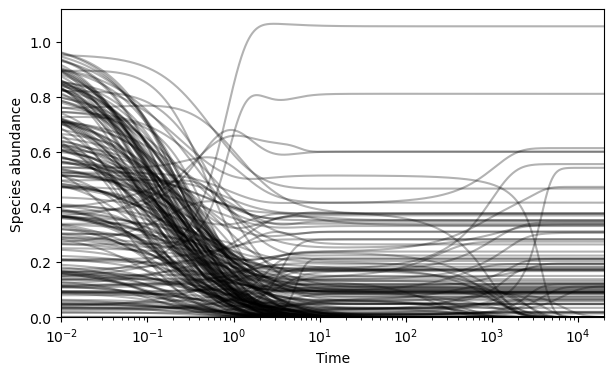

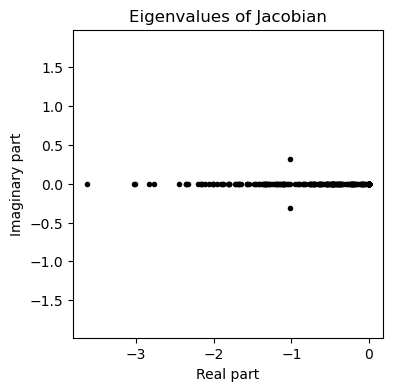

In [17]:
from scipy.integrate import solve_ivp

## Load local functions
import sys
import base
import utils
from base import RandomLotkaVolterra
from utils import levenshtein


tlim = (0, 20000) # Integration interval
n_val = 200 # Number of species

## Initialize the model
eq = RandomLotkaVolterra(n_val, sigma=2.0, d=4.5, kfrac=0.2, eps=0.001, random_state=0, connectivity=0.01)

## Initial conditions
ic = np.random.uniform(size=eq.n)

## Numerical integration
fsol = solve_ivp(eq, tlim, ic[:n_val], jac=eq.jac, **eq.integrator_args)


## Check that the found solution is stable
sol_final = fsol.y[:, -1]
jac_final = eq.jac(0, sol_final)
eigs = np.linalg.eigvals(jac_final)
print(f"Numerical stability observed: {np.all(np.real(eigs) < 0)}")

## Plot the solution
plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, fsol.y.T, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(fsol.t))
plt.ylim(0, None)

eigvals = np.linalg.eigvals(jac_final)
plt.figure(figsize=(4, 4))
plt.plot(np.real(eigvals), np.imag(eigvals), '.k')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.axis("equal")
plt.title("Eigenvalues of Jacobian")

## Dimensionality reduction as preconditioning

Original condition number:  723977.2579774971
Fast condition number:  1.8180378841429419
Slow condition number:  3.1628804216115274


(0.01, 20000.0)

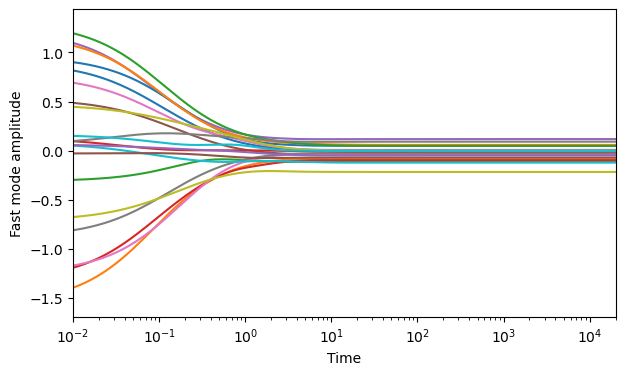

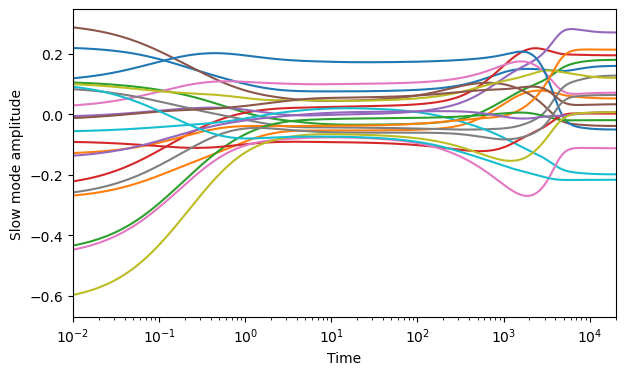

In [21]:
## Separate timescales

print("Original condition number: ", np.linalg.cond(eq.A))




U, S, V = np.linalg.svd(eq.A)
P_fast, P_slow = V[:20, :], V[-20:, :]
yp_fast = P_fast @ fsol.y # First k modes
yp_slow = P_slow @ fsol.y # Last k modes

print("Fast condition number: ", np.linalg.cond(P_fast @ eq.A))
print("Slow condition number: ", np.linalg.cond(P_slow @ eq.A))


plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, yp_fast.T);
plt.xlabel("Time")
plt.ylabel("Fast mode amplitude")
plt.xlim(1e-2, np.max(fsol.t))
# dg.better_savefig("lv_traj_fast_dark.png", dpi=600)

plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, yp_slow.T);
plt.xlabel("Time")
plt.ylabel("Slow mode amplitude")
plt.xlim(1e-2, np.max(fsol.t))
# dg.better_savefig("lv_traj_slow_dark.png", dpi=600)

